# Data Preperation

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec 15 14:23:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [109]:
import matplotlib.pyplot as plt
import numpy as np

In [110]:
import pandas as pd
import csv
df = pd.read_csv("train.csv", encoding="latin")

In [111]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [112]:
df.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [114]:
print("Number of products :", len(df["product_uid"].unique()))
print("Total number of data points :",df.shape[0])

Number of products : 54667
Total number of data points : 74067


In [6]:
attributes = pd.read_csv("attributes.csv")

In [7]:
attributes.tail()

,product_uid,name,value
2044798,224428.0,Pilot Bit Included,No
2044799,224428.0,Power Tool Product Type,Drill & Router Bits
2044800,224428.0,Shank Diameter,3/8 in
2044801,224428.0,Shank Style,Hex
2044802,224428.0,Tools Product Type,Power Tool


In [8]:
product_descriptions = pd.read_csv("product_descriptions.csv")

In [9]:
product_descriptions.set_index("product_uid",inplace=True)

In [10]:
product_descriptions.head()

,product_description
product_uid,
100001,"Not only do angles make joints stronger, they ..."
100002,BEHR Premium Textured DECKOVER is an innovativ...
100003,Classic architecture meets contemporary design...
100004,The Grape Solar 265-Watt Polycrystalline PV So...
100005,Update your bathroom with the Delta Vero Singl...


In [11]:
# using the code I had written in assignment 1. 

import re
import string

class Preprocesser(object):
    def __init__(self, punctuation=True, url=True):
        self.punctuation = punctuation
        self.url = url
    
    def apply(self, text):
        
        text = self._lowercase(text)
        
        if self.url:
            text = self._remove_url(text)
            
        if self.punctuation:
            text = self._remove_punctuation(text)
            
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
        
    def _remove_punctuation(self, text):
                
        for c in string.punctuation:
            text = re.sub(f"\{c}"," ",text)
        
        return text
    
    def _remove_url(self, text):
        text = re.sub(r'http\S+',"",text)
        return text
    
    def _lowercase(self, text):
        return text.lower()

In [12]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
wordsToRemove = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [14]:

def tokenize(text):
    return [lemmatizer.lemmatize(x) for x in text.split(" ") if x not in wordsToRemove]

In [15]:
preprocesser = Preprocesser()

In [16]:
df["preprocessed_title"] = df["product_title"].astype(str).apply(lambda x: preprocesser.apply(x)).apply(lambda x : tokenize(x))

In [17]:
df["product_description"] = df["product_uid"].astype(int).apply(lambda x: product_descriptions.loc[x].product_description)

In [18]:
df["preprocessed_description"] = df["product_description"].astype(str).apply(lambda x: preprocesser.apply(x)).apply(lambda x : tokenize(x))


In [19]:
def getAttributes(product_id):
    
    temp = attributes[attributes["product_uid"]==product_id][["name","value"]]
        
    answer = temp.apply(lambda x : f'{x["name"]} {x["value"]}',axis=1)
    
    result = " ".join(answer.values.tolist())
    
    return  result


df["product_attributes"] =  df["product_uid"].astype(int).apply(lambda x: getAttributes(x))

In [20]:
df.head()

,id,product_uid,product_title,search_term,relevance,preprocessed_title,product_description,preprocessed_description,product_attributes
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"[simpson, strong, tie, 12, gauge, angle]","Not only do angles make joints stronger, they ...","[angle, make, joint, stronger, also, provide, ...",Bullet01 Versatile connector for various 90° c...
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"[simpson, strong, tie, 12, gauge, angle]","Not only do angles make joints stronger, they ...","[angle, make, joint, stronger, also, provide, ...",Bullet01 Versatile connector for various 90° c...
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,"[behr, premium, textured, deckover, 1, gal, sc...",BEHR Premium Textured DECKOVER is an innovativ...,"[behr, premium, textured, deckover, innovative...","Application Method Brush,Roller,Spray Assemble..."
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,"[delta, vero, 1, handle, shower, faucet, trim,...",Update your bathroom with the Delta Vero Singl...,"[update, bathroom, delta, vero, single, handle...",Bath Faucet Type Combo Tub and Shower Built-in...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,"[delta, vero, 1, handle, shower, faucet, trim,...",Update your bathroom with the Delta Vero Singl...,"[update, bathroom, delta, vero, single, handle...",Bath Faucet Type Combo Tub and Shower Built-in...


In [21]:
df.to_csv("prepared_data.csv",index=False)

In [22]:
df.tail(4)

,id,product_uid,product_title,search_term,relevance,preprocessed_title,product_description,preprocessed_description,product_attributes
74063,221458,206639,Philips 40-Watt Halogen R20 Flood Light Bulb (...,r20 halogen light,3.00,"[philip, 40, watt, halogen, r20, flood, light,...",Philips Energy Advantage lamps use less energy...,"[philip, energy, advantage, lamp, use, le, ene...",Actual Color Temperature (K) 2700 Average Life...
74064,221463,206641,Schlage Camelot In-Active Aged Bronze Handlese...,schlage lock siena half dummy knob with,2.33,"[schlage, camelot, active, aged, bronze, handl...",The Schlage Camelot In-Active Aged Bronze Hand...,"[schlage, camelot, active, aged, bronze, handl...",Application Type Entry Assembled Depth (in.) 2...
74065,221471,206648,Plastec 11 in. x 24 in. Rose Garden Wall Decor...,zen garden decor,3.00,"[plastec, 11, x, 24, rose, garden, wall, decor...",The Rose Garden is inspired by the popular ear...,"[rose, garden, inspired, popular, early, 20th,...",Bullet01 Indoor and outdoor use Bullet02 Finis...
74066,221473,206650,LICHTENBERG Pool Blue No. 918 Millennial Ryan ...,fine sheer curtain 63 inches,2.33,"[lichtenberg, pool, blue, 918, millennial, rya...",No. 918 Millennial Ryan heathered texture semi...,"[918, millennial, ryan, heathered, texture, se...",Assembled Depth (in.) .1 in Assembled Height (...


In [23]:
df["preprocessed_title"] = df["preprocessed_title"].apply(lambda x: " ".join(x))
df["preprocessed_description"] = df["preprocessed_description"].apply(lambda x: " ".join(x))

In [24]:
df["preprocessed_attributes"] = df["product_attributes"].apply(lambda x: preprocesser.apply(x))

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
train, test = train_test_split(df,test_size=0.2) 

In [27]:
train, cv = train_test_split(train,test_size=0.2)

In [28]:
train.shape, cv.shape, test.shape

((47402, 10), (11851, 10), (14814, 10))

#  Encoding

In [77]:
from tensorflow.keras.preprocessing.text import Tokenizer
title_encoder = Tokenizer(oov_token="<ukn>")
title_encoder.fit_on_texts(train["preprocessed_title"].values)
train_titles = title_encoder.texts_to_sequences(train["preprocessed_title"].values)
cv_titles = title_encoder.texts_to_sequences(cv["preprocessed_title"].values)
test_titles = title_encoder.texts_to_sequences(test["preprocessed_title"].values)

In [78]:
description_encoder = Tokenizer(oov_token="<ukn>",num_words=10000)
description_encoder.fit_on_texts(train["preprocessed_description"].values)
train_description = description_encoder.texts_to_sequences(train["preprocessed_description"].values)
cv_description = description_encoder.texts_to_sequences(cv["preprocessed_description"].values)
test_description = description_encoder.texts_to_sequences(test["preprocessed_description"].values)

In [79]:
attribute_encoder = Tokenizer(oov_token="<ukn>",num_words=10000)
attribute_encoder.fit_on_texts(train["preprocessed_attributes"].values)
train_attribute = attribute_encoder.texts_to_sequences(train["preprocessed_attributes"].values)
cv_attribute = attribute_encoder.texts_to_sequences(cv["preprocessed_attributes"].values)
test_attribute = attribute_encoder.texts_to_sequences(test["preprocessed_attributes"].values)

In [80]:
search_term_encoder = Tokenizer(oov_token="<ukn>")
search_term_encoder.fit_on_texts(train["search_term"].values)
train_search_term = search_term_encoder.texts_to_sequences(train["search_term"].values)
cv_search_term = search_term_encoder.texts_to_sequences(cv["search_term"].values)
test_search_term = search_term_encoder.texts_to_sequences(test["search_term"].values)

In [81]:
max_length_of_titles =  max([len(x) for x in train_titles])
length_of_descr = np.sort([len(x) for x in  train_description])
length_of_attribute = np.sort([len(x) for x in train_attribute])

In [82]:
max_length_of_titles

34

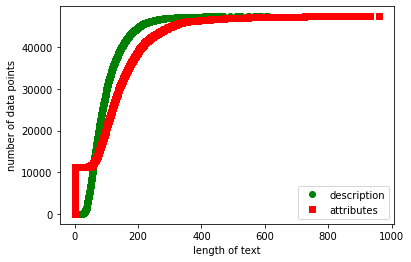

In [83]:
plt.plot(length_of_descr,range(len(length_of_descr)),"go")
plt.plot(length_of_attribute,range(len(length_of_attribute)),"rs")
plt.xlabel("length of text")
plt.ylabel("number of data points")
plt.legend(["description","attributes"])

In [84]:
max_length_of_search_term =  max([len(x) for x in train_search_term])
max_length_of_search_term

17

In [85]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_titles = pad_sequences(train_titles,maxlen=max_length_of_titles)
cv_titles = pad_sequences(cv_titles,maxlen=max_length_of_titles)
test_titles = pad_sequences(test_titles,maxlen=max_length_of_titles)

train_description = pad_sequences(train_description,maxlen=200,truncating="post")
cv_description = pad_sequences(cv_description,maxlen=200,truncating="post")
test_description = pad_sequences(test_description,maxlen=200,truncating="post")

train_attribute = pad_sequences(train_attribute,maxlen=200,truncating="post")
cv_attribute = pad_sequences(cv_attribute,maxlen=200,truncating="post")
test_attribute = pad_sequences(test_attribute,maxlen=200,truncating="post")

train_search_term = pad_sequences(train_search_term,maxlen=max_length_of_search_term)
cv_search_term = pad_sequences(cv_search_term,maxlen=max_length_of_search_term)
test_search_term = pad_sequences(test_search_term,maxlen=max_length_of_search_term)

In [86]:
title_vocab_len = len(title_encoder.word_index)
descr_vocab_len = len(description_encoder.word_index)
attr_vocab_len = len(attribute_encoder.word_index)
search_vocab_len = len(search_term_encoder.word_index)

# Modeling

In [87]:
from keras import  backend
backend.clear_session()

In [88]:
from keras.layers import Bidirectional,LSTM,Dense, Input, Embedding, concatenate, Dot
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, median_absolute_error
from keras.callbacks import  EarlyStopping
from keras.metrics import RootMeanSquaredError

### Bidirectional LSTM

In [89]:
title_input = Input(shape=(max_length_of_titles))
embedding_layer = Embedding(title_vocab_len+1,50,input_length=max_length_of_titles)
emb_vecs = embedding_layer(title_input)
lstm_1 = Bidirectional(LSTM(100,return_sequences=True))(emb_vecs)
title_output = Bidirectional(LSTM(100))(lstm_1)

In [90]:
description_input = Input(shape=(200))
embedding_layer = Embedding(descr_vocab_len+1,100,input_length=200)
emb_vecs = embedding_layer(description_input)
lstm_1 = Bidirectional(LSTM(100,return_sequences=True))(emb_vecs)
description_output = Bidirectional(LSTM(100))(lstm_1)

In [91]:
attribute_input = Input(shape=(200))
embedding_layer = Embedding(attr_vocab_len+1,100,input_length=200)
emb_vecs = embedding_layer(attribute_input)
lstm_1 = Bidirectional(LSTM(100,return_sequences=True))(emb_vecs)
attribute_output = Bidirectional(LSTM(100))(lstm_1)

In [92]:
search_term_input = Input(shape=(max_length_of_search_term))
embedding_layer = Embedding(search_vocab_len+1,100,input_length=max_length_of_search_term)
emb_vecs = embedding_layer(search_term_input)
search_term_output = Bidirectional(LSTM(100))(emb_vecs)

In [93]:
cosine_similarity1 = Dot(axes=-1,normalize=True)([title_output,search_term_output])
cosine_similarity2 = Dot(axes=-1,normalize=True)([description_output,search_term_output])
cosine_similarity3 = Dot(axes=-1,normalize=True)([attribute_output,search_term_output])

In [94]:
concat_inputs = concatenate([cosine_similarity1,cosine_similarity2,cosine_similarity2])
all_inputs = Dense(10,activation="relu")(concat_inputs)

In [95]:
output_layer = Dense(1,activation="linear")(all_inputs)

In [96]:
model = Model(inputs=[title_input,description_input,attribute_input,search_term_input], outputs=output_layer)

In [97]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 50)       757850      ['input_1[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 17)]         0           []                               
                                                                                              

In [98]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=[RootMeanSquaredError()])

In [99]:
y_train = train["relevance"].values.reshape(-1,1)
y_cv = cv["relevance"].values.reshape(-1,1)
y_test = test["relevance"].values.reshape(-1,1)

In [100]:
history = model.fit(x=[train_titles,train_description,train_attribute,train_search_term],y=y_train,epochs=15,batch_size=1024,callbacks=[EarlyStopping(patience=2,restore_best_weights=True)] ,validation_data=(
    [cv_titles,cv_description,cv_attribute,cv_search_term],y_cv
))

Epoch 1/15
47/47 [==============================] - 31s 345ms/step - loss: 3.4377 - root_mean_squared_error: 1.8541 - val_loss: 2.7408 - val_root_mean_squared_error: 1.6555
Epoch 2/15
47/47 [==============================] - 13s 275ms/step - loss: 2.3288 - root_mean_squared_error: 1.5260 - val_loss: 1.9082 - val_root_mean_squared_error: 1.3814
Epoch 3/15
47/47 [==============================] - 13s 275ms/step - loss: 1.6078 - root_mean_squared_error: 1.2680 - val_loss: 1.2973 - val_root_mean_squared_error: 1.1390
Epoch 4/15
47/47 [==============================] - 13s 275ms/step - loss: 1.0746 - root_mean_squared_error: 1.0366 - val_loss: 0.8502 - val_root_mean_squared_error: 0.9220
Epoch 5/15
47/47 [==============================] - 13s 275ms/step - loss: 0.6966 - root_mean_squared_error: 0.8347 - val_loss: 0.5514 - val_root_mean_squared_error: 0.7426
Epoch 6/15
47/47 [==============================] - 13s 275ms/step - loss: 0.4618 - root_mean_squared_error: 0.6796 - val_loss: 0.3857 

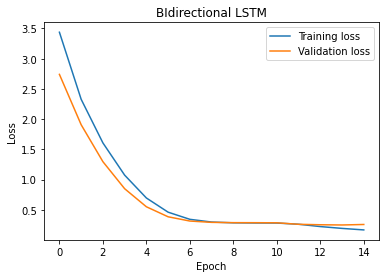

In [101]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(range(len(history.history["loss"])), history.history["loss"], history.history["val_loss"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training loss", "Validation loss"])
plt.title('BIdirectional LSTM')
plt.show()

In [102]:
y_pred = model.predict([test_titles,test_description,test_attribute,test_search_term])

In [103]:
rmse = mean_squared_error(y_pred,y_test,squared=False)
mse = mean_squared_error(y_pred,y_test)
mae = median_absolute_error(y_pred,y_test)

print("RMSE on test data :",rmse)
print("MSE on test data  :",mse)
print("MAE on test data  :",mae)

RMSE on test data : 0.5102083332175582
MSE on test data  : 0.26031254328463893
MAE on test data  : 0.38851141929626465


Text(0.5, 1.0, 'Analysis on BiLSTM')

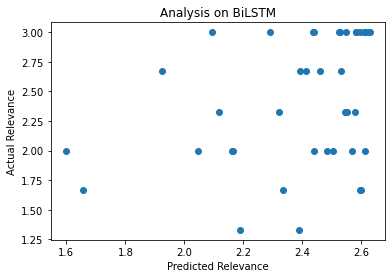

In [104]:
plt.scatter(y_pred[:40],y_test[:40])
plt.xlabel("Predicted Relevance")
plt.ylabel("Actual Relevance")
plt.title("Analysis on BiLSTM")

In [107]:
import time

t = time.time()
title = title_encoder.texts_to_sequences(test["preprocessed_title"].values[0:1])
descr = description_encoder.texts_to_sequences(test["preprocessed_description"].values[0:1])
attr = attribute_encoder.texts_to_sequences(test["preprocessed_attributes"].values[0:1])
search_term_ = search_term_encoder.texts_to_sequences(test["search_term"].values[0:1])

title = pad_sequences(title,maxlen=max_length_of_titles)
descr = pad_sequences(descr,maxlen=200,truncating="post")
attr = pad_sequences(attr,maxlen=200,truncating="post")
search_term_ = pad_sequences(search_term_,maxlen=max_length_of_search_term)

pred = model.predict([title,descr,attr,search_term_])
time_taken = time.time()-t
print("Time taken by BI LSTM model to predict the relevance: ",time_taken)

Time taken by BI LSTM model to predict the relevance:  0.06016254425048828


### Conv1D

In [176]:
backend.clear_session()
from keras.layers import Conv1D, GlobalMaxPooling1D, Dropout

In [177]:
title_input = Input(shape=(max_length_of_titles))
embedding_layer = Embedding(title_vocab_len+1,50,input_length=max_length_of_titles)
emb_vecs = embedding_layer(title_input)
drop_out = Dropout(0.25)(emb_vecs)
conv = Conv1D(100, 5, activation='relu',padding="same")(drop_out)
title_output = GlobalMaxPooling1D()(conv)

In [178]:
description_input = Input(shape=(200))
embedding_layer = Embedding(descr_vocab_len+1,100,input_length=200)
emb_vecs = embedding_layer(description_input)
drop_out = Dropout(0.25)(emb_vecs)
conv = Conv1D(100, 5, activation='relu',padding="same")(drop_out)

description_output = GlobalMaxPooling1D()(conv)

In [179]:
attribute_input = Input(shape=(200))
embedding_layer = Embedding(attr_vocab_len+1,100,input_length=200)
emb_vecs = embedding_layer(attribute_input)
drop_out = Dropout(0.25)(emb_vecs)
conv = Conv1D(100, 5, activation='relu',padding="same")(drop_out)
attribute_output = GlobalMaxPooling1D()(conv)

In [180]:
search_term_input = Input(shape=(max_length_of_search_term))
embedding_layer = Embedding(search_vocab_len+1,100,input_length=max_length_of_search_term)
drop_out = Dropout(0.25)(emb_vecs)
conv = Conv1D(100, 5, activation='relu',padding="same")(drop_out)
search_term_output = GlobalMaxPooling1D()(conv)

In [181]:
# Dot layer is similar to cosine similarity when normalize is set to TRUE.
cosine_similarity1 = Dot(axes=-1,normalize=True)([title_output,search_term_output])
cosine_similarity2 = Dot(axes=-1,normalize=True)([description_output,search_term_output])
cosine_similarity3 = Dot(axes=-1,normalize=True)([attribute_output,search_term_output])

In [182]:
concat_inputs = concatenate([cosine_similarity1,cosine_similarity2,cosine_similarity3])
concat_inputs = Dense(64,activation="relu")(concat_inputs)
all_inputs = Dense(10,activation="relu")(concat_inputs)

In [183]:
output_layer = Dense(1,activation="linear")(all_inputs)

In [184]:
model = Model(inputs=[title_input,description_input,attribute_input,search_term_input], outputs=output_layer)

In [185]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 32, 50)       754050      ['input_1[0][0]']                
                                                                                              

In [186]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='mse',
    metrics=[RootMeanSquaredError()])

In [187]:
history2 = model.fit(x=[train_titles,train_description,train_attribute,train_search_term],y=y_train,epochs=35,batch_size=1024,callbacks=[EarlyStopping(patience=2,restore_best_weights=True)] ,validation_data=(
    [cv_titles,cv_description,cv_attribute,cv_search_term],y_cv
))

Epoch 1/35
47/47 [==============================] - 6s 97ms/step - loss: 5.4081 - root_mean_squared_error: 2.3255 - val_loss: 4.9826 - val_root_mean_squared_error: 2.2322
Epoch 2/35
47/47 [==============================] - 4s 92ms/step - loss: 4.5409 - root_mean_squared_error: 2.1309 - val_loss: 4.1176 - val_root_mean_squared_error: 2.0292
Epoch 3/35
47/47 [==============================] - 4s 92ms/step - loss: 3.8054 - root_mean_squared_error: 1.9508 - val_loss: 3.4245 - val_root_mean_squared_error: 1.8505
Epoch 4/35
47/47 [==============================] - 4s 92ms/step - loss: 3.1708 - root_mean_squared_error: 1.7807 - val_loss: 2.8708 - val_root_mean_squared_error: 1.6943
Epoch 5/35
47/47 [==============================] - 4s 92ms/step - loss: 2.6595 - root_mean_squared_error: 1.6308 - val_loss: 2.4096 - val_root_mean_squared_error: 1.5523
Epoch 6/35
47/47 [==============================] - 4s 95ms/step - loss: 2.2282 - root_mean_squared_error: 1.4927 - val_loss: 2.0088 - val_root_m

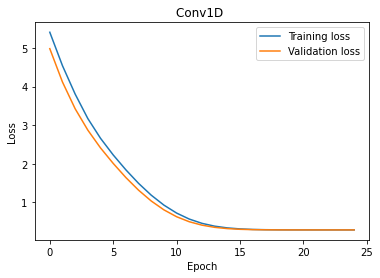

In [193]:
plt.plot(range(len(history2.history["loss"])), history2.history["loss"], history2.history["val_loss"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training loss", "Validation loss"])
plt.title('Conv1D ')
plt.show()

In [194]:
y_pred = model.predict([test_titles,test_description,test_attribute,test_search_term])

rmse = mean_squared_error(y_pred,y_test,squared=False)
mse = mean_squared_error(y_pred,y_test)
mae = median_absolute_error(y_pred,y_test)

print("RMSE on test data :",rmse)
print("MSE on test data  :",mse)
print("MAE on test data  :",mae)


RMSE on test data : 0.5343988777205347
MSE on test data  : 0.285582160508967
MAE on test data  : 0.3802490234375


Text(0.5, 1.0, 'Analysis on Conv1D')

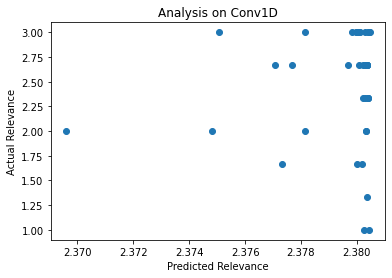

In [195]:
plt.scatter(y_pred[:40],y_test[:40])
plt.xlabel("Predicted Relevance")
plt.ylabel("Actual Relevance")
plt.title("Analysis on Conv1D")

In [196]:
import time
t = time.time()
title = title_encoder.texts_to_sequences(test["preprocessed_title"].values[0:1])
descr = description_encoder.texts_to_sequences(test["preprocessed_description"].values[0:1])
attr = attribute_encoder.texts_to_sequences(test["preprocessed_attributes"].values[0:1])
search_term_ = search_term_encoder.texts_to_sequences(test["search_term"].values[0:1])

title = pad_sequences(title,maxlen=max_length_of_titles)
descr = pad_sequences(descr,maxlen=200,truncating="post")
attr = pad_sequences(attr,maxlen=200,truncating="post")
search_term_ = pad_sequences(search_term_,maxlen=max_length_of_search_term)

pred = model.predict([title,descr,attr,search_term_])
time_taken = time.time()-t
print("Time taken by conv 1D model to predict the relevance: ",time_taken)

Time taken by conv 1D model to predict the relevance:  0.05159807205200195


### Attention

In [197]:
backend.clear_session()
from keras.layers import AdditiveAttention
import tensorflow as tf

In [198]:
title_input = Input(shape=(max_length_of_titles))
embedding_layer = Embedding(title_vocab_len+1,50,input_length=max_length_of_titles)
emb_vecs = embedding_layer(title_input)
title_output, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(100,return_state=True,dropout=0.25))(emb_vecs)
title_state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
title_state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])

In [199]:
description_input = Input(shape=(200))
embedding_layer = Embedding(descr_vocab_len+1,100,input_length=200)
emb_vecs = embedding_layer(description_input)
description_output, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(100,return_state=True,dropout=0.25))(emb_vecs)
description_state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
description_state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])

In [200]:
attribute_input = Input(shape=(200))
embedding_layer = Embedding(attr_vocab_len+1,100,input_length=200)
emb_vecs = embedding_layer(attribute_input)
attr_output, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(100,return_state=True,dropout=0.25))(emb_vecs)
attr_state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
attr_state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])

In [201]:
search_term_input = Input(shape=(max_length_of_search_term))
embedding_layer = Embedding(search_vocab_len+1,100,input_length=max_length_of_search_term)
emb_vecs = embedding_layer(search_term_input)
search_term_output = Bidirectional(LSTM(100))(emb_vecs)

In [202]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.w1 = Dense(units)
        self.w2 = Dense(units)
        self.V = Dense(1)
    def call(self, input, h_state):
        hidden_with_time_axis = tf.expand_dims(h_state, 1)
        score = tf.nn.tanh(self.w1(input) + self.w2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * input
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [203]:
context_vector1, attention_weights = Attention(100)(search_term_output, title_state_h)
context_vector2, attention_weights = Attention(100)(search_term_output, description_state_h)
context_vector3, attention_weights = Attention(100)(search_term_output, attr_state_h)

In [204]:
concat_layer = concatenate([context_vector1,context_vector2,context_vector3])
dense = Dense(10,activation="relu")(concat_layer)
output_layer = Dense(1,activation="linear")(dense)

In [205]:
model = Model(inputs=[title_input,description_input,attribute_input,search_term_input], outputs=output_layer)

In [206]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 17)]         0           []                               
                                                                                              

In [207]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='mse',
    metrics=[RootMeanSquaredError()])

In [208]:
history3 = model.fit(x=[train_titles,train_description,train_attribute,train_search_term],y=y_train,epochs=35,batch_size=1024,callbacks=[EarlyStopping(patience=2,restore_best_weights=True)] ,validation_data=(
    [cv_titles,cv_description,cv_attribute,cv_search_term],y_cv
))

Epoch 1/35
47/47 [==============================] - 31s 408ms/step - loss: 5.2142 - root_mean_squared_error: 2.2835 - val_loss: 3.8356 - val_root_mean_squared_error: 1.9585
Epoch 2/35
47/47 [==============================] - 16s 349ms/step - loss: 1.4382 - root_mean_squared_error: 1.1993 - val_loss: 0.2941 - val_root_mean_squared_error: 0.5423
Epoch 3/35
47/47 [==============================] - 16s 349ms/step - loss: 0.2918 - root_mean_squared_error: 0.5402 - val_loss: 0.2850 - val_root_mean_squared_error: 0.5339
Epoch 4/35
47/47 [==============================] - 16s 348ms/step - loss: 0.2851 - root_mean_squared_error: 0.5340 - val_loss: 0.2850 - val_root_mean_squared_error: 0.5339
Epoch 5/35
47/47 [==============================] - 16s 350ms/step - loss: 0.2852 - root_mean_squared_error: 0.5340 - val_loss: 0.2852 - val_root_mean_squared_error: 0.5341


In [210]:
y_pred = model.predict([test_titles,test_description,test_attribute,test_search_term])

rmse = mean_squared_error(y_pred,y_test,squared=False)
mse = mean_squared_error(y_pred,y_test)
mae = median_absolute_error(y_pred,y_test)

print("RMSE on test data :",rmse)
print("MSE on test data  :",mse)
print("MAE on test data  :",mae)

RMSE on test data : 0.5351345961540366
MSE on test data  : 0.2863690360009438
MAE on test data  : 0.37949609756469727


In [214]:
t = time.time()
title = title_encoder.texts_to_sequences(test["preprocessed_title"].values[0:1])
descr = description_encoder.texts_to_sequences(test["preprocessed_description"].values[0:1])
attr = attribute_encoder.texts_to_sequences(test["preprocessed_attributes"].values[0:1])
search_term_ = search_term_encoder.texts_to_sequences(test["search_term"].values[0:1])

title = pad_sequences(title,maxlen=max_length_of_titles)
descr = pad_sequences(descr,maxlen=200,truncating="post")
attr = pad_sequences(attr,maxlen=200,truncating="post")
search_term_ = pad_sequences(search_term_,maxlen=max_length_of_search_term)

pred = model.predict([title,descr,attr,search_term_])
time_taken = time.time()-t
print("Time taken by Attention model to predict the relevance: ",time_taken)

Time taken by Attention model to predict the relevance:  0.06629800796508789


### BERT

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
import re

In [ ]:
!pip install sentencepiece
!gdown --id 13exfXiyiByluh1PfYK1EyZyizqxeCVG9

Downloading...
From: https://drive.google.com/uc?id=13exfXiyiByluh1PfYK1EyZyizqxeCVG9
To: /content/tokenization.py
100% 17.3k/17.3k [00:00<00:00, 15.6MB/s]


In [ ]:
from keras import backend
backend.clear_session()

In [ ]:

max_seq_length = 34

input_word_ids = Input(shape=(max_seq_length,), dtype=tf.int32)
input_mask = Input(shape=(max_seq_length,), dtype=tf.int32)
segment_ids = Input(shape=(max_seq_length,), dtype=tf.int32)

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
import tokenization
tokenizer=tokenization.FullTokenizer(vocab_file,do_lower_case )

In [ ]:
def mask_and_segment(text_array,max_seq_length):
  X_mask=[]
  X_segment=[]
  X_tokens=[]
  for t in text_array:
      token = tokenizer.tokenize(t)
      if len(token)==max_seq_length-2:
              tokens = ['[CLS]',*token,'[SEP]']
      elif len(token)>max_seq_length-2:
              tokens = ['[CLS]',*token[:max_seq_length-2],'[SEP]']
      else:
              pad_len = (max_seq_length-2)-len(token)
              pads = ['[PAD]']*pad_len
              tokens = ['[CLS]',*token,*pads,'[SEP]']
      mask = [1 if i!='[PAD]' else 0 for i in tokens]
      segment = [0]*max_seq_length
      tokens = tokenizer.convert_tokens_to_ids(tokens)  
      X_mask.append(mask)  
      X_segment.append(segment)  
      X_tokens.append(tokens)   
  return (np.array(X_tokens),np.array(X_mask),np.array(X_segment))     

In [ ]:
train_titles_tokens,train_titles_mask,train_titles_segment = mask_and_segment(train['preprocessed_title'],34)
cv_titles_tokens,cv_titles_mask,cv_titles_segment = mask_and_segment(cv['preprocessed_title'],34)
test_titles_tokens,test_titles_mask,test_titles_segment = mask_and_segment(test['preprocessed_title'],34)

train_titles_pooled_output=bert_model.predict((train_titles_tokens,train_titles_mask,train_titles_segment))
cv_titles_pooled_output=bert_model.predict((cv_titles_tokens,cv_titles_mask,cv_titles_segment))
test_titles_pooled_output=bert_model.predict((test_titles_tokens,test_titles_mask,test_titles_segment))

In [ ]:
max_seq_length = 200

input_word_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

input_mask = Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

segment_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

bert_model_2 = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)

In [ ]:
train_description_tokens,train_description_mask,train_description_segment = mask_and_segment(train['preprocessed_description'],200)
cv_description_tokens,cv_description_mask,cv_description_segment = mask_and_segment(cv['preprocessed_description'],200)
test_description_tokens,test_description_mask,test_description_segment = mask_and_segment(test['preprocessed_description'],200)
train_description_pooled_output=bert_model_2.predict((train_description_tokens,train_description_mask,train_description_segment))
cv_description_pooled_output=bert_model_2.predict((cv_description_tokens,cv_description_mask,cv_description_segment))
test_description_pooled_output=bert_model_2.predict((test_description_tokens,test_description_mask,test_description_segment))

In [ ]:
train_attributes_tokens,train_attributes_mask,train_attributes_segment = mask_and_segment(train['preprocessed_attributes'],200)
cv_attributes_tokens,cv_attributes_mask,cv_attributes_segment = mask_and_segment(cv['preprocessed_attributes'],200)
test_attributes_tokens,test_attributes_mask,test_attributes_segment = mask_and_segment(test['preprocessed_attributes'],200)

train_attributes_pooled_output=bert_model_2.predict((train_attributes_tokens,train_attributes_mask,train_attributes_segment))
cv_attributes_pooled_output=bert_model_2.predict((cv_attributes_tokens,cv_attributes_mask,cv_attributes_segment))
test_attributes_pooled_output=bert_model_2.predict((test_attributes_tokens,test_attributes_mask,test_attributes_segment))

In [ ]:
max_seq_length = 17

input_word_ids = Input(shape=(max_seq_length,), dtype=tf.int32)

input_mask = Input(shape=(max_seq_length,), dtype=tf.int32)

segment_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

bert_model_3 = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)

In [ ]:
train_search_term_tokens,train_search_term_mask,train_search_term_segment = mask_and_segment(train['search_term'],17)
cv_search_term_tokens,cv_search_term_mask,cv_search_term_segment = mask_and_segment(cv['search_term'],17)
test_search_term_tokens,test_search_term_mask,test_search_term_segment = mask_and_segment(test['search_term'],17)

train_search_term_pooled_output=bert_model_3.predict((train_search_term_tokens,train_search_term_mask,train_search_term_segment))
cv_search_term_pooled_output=bert_model_3.predict((cv_search_term_tokens,cv_search_term_mask,cv_search_term_segment))
test_search_term_pooled_output=bert_model_3.predict((test_search_term_tokens,test_search_term_mask,test_search_term_segment))

In [ ]:
from tensorflow.keras.layers import Input, Dense, Activation, Dropout,BatchNormalization, concatenate,Dot
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,LearningRateScheduler
from tensorflow.keras.models import Model,load_model
from tensorflow.keras import backend
backend.clear_session()

title_input = Input((768,))
title_dense = Dense(256,activation='linear')(title_input)

description_input = Input((768,))
drop_out = Dropout(.25)(description_input)
description_dense = Dense(256,activation='linear')(drop_out)

attribute_input = Input((768,))
drop_out = Dropout(.25)(attribute_input)
attribute_dense = Dense(256,activation='linear')(drop_out)

search_term_input = Input((768,))
drop_out = Dropout(.25)(search_term_input)
search_term_dense = Dense(256,activation='linear')(drop_out)

concat_layer = concatenate([title_dense,description_dense,attribute_dense,search_term_dense])
dense_layer = Dense(128,activation="linear")(concat_layer)
dense_layer = Dense(64,activation="relu")(dense_layer)
output_layer = Dense(1,activation='linear')(dense_layer)
model = Model(inputs = [title_input,description_input,attribute_input,search_term_input],outputs = output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 768)]        0           []                               
                                                                                              

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='mse',
    metrics=[RootMeanSquaredError()])

In [ ]:
history4 = model.fit(x=[train_titles_pooled_output,train_description_pooled_output,train_attributes_pooled_output,train_search_term_pooled_output],y=y_train,epochs=35,batch_size=1024,callbacks=[EarlyStopping(patience=2,restore_best_weights=True)] ,validation_data=(
    [cv_titles_pooled_output,cv_description_pooled_output,cv_attributes_pooled_output,cv_search_term_pooled_output],y_cv
))

Epoch 1/35
47/47 [==============================] - 1s 14ms/step - loss: 2.6031 - root_mean_squared_error: 1.6134 - val_loss: 0.4092 - val_root_mean_squared_error: 0.6397
Epoch 2/35
47/47 [==============================] - 0s 10ms/step - loss: 0.6323 - root_mean_squared_error: 0.7952 - val_loss: 0.3383 - val_root_mean_squared_error: 0.5816
Epoch 3/35
47/47 [==============================] - 0s 9ms/step - loss: 0.5555 - root_mean_squared_error: 0.7453 - val_loss: 0.3235 - val_root_mean_squared_error: 0.5688
Epoch 4/35
47/47 [==============================] - 0s 9ms/step - loss: 0.5172 - root_mean_squared_error: 0.7192 - val_loss: 0.3104 - val_root_mean_squared_error: 0.5571
Epoch 5/35
47/47 [==============================] - 0s 9ms/step - loss: 0.4955 - root_mean_squared_error: 0.7039 - val_loss: 0.3040 - val_root_mean_squared_error: 0.5513
Epoch 6/35
47/47 [==============================] - 0s 9ms/step - loss: 0.4730 - root_mean_squared_error: 0.6878 - val_loss: 0.2988 - val_root_mean_

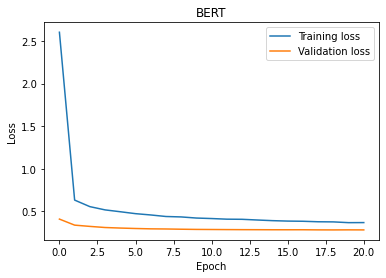

In [ ]:
plt.plot(range(len(history4.history["loss"])), history4.history["loss"], history4.history["val_loss"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training loss", "Validation loss"])
plt.title('BERT')
plt.show()

In [ ]:
y_pred = model.predict([test_titles_pooled_output,test_description_pooled_output,test_attributes_pooled_output,test_search_term_pooled_output])

rmse = mean_squared_error(y_pred,y_test,squared=False)
mse = mean_squared_error(y_pred,y_test)
mae = median_absolute_error(y_pred,y_test)

print("RMSE on test data :",rmse)
print("MSE on test data  :",mse)
print("MAE on test data  :",mae)


RMSE on test data : 0.527874183274473
MSE on test data  : 0.27865115336769186
MAE on test data  : 0.39746900558471676


Text(0.5, 1.0, 'Analysis on Conv1D')

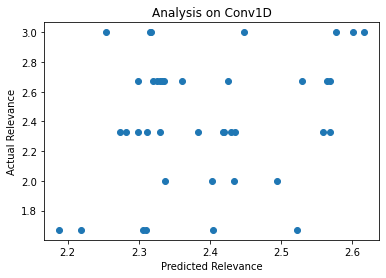

In [ ]:
plt.scatter(y_pred[:40],y_test[:40])
plt.xlabel("Predicted Relevance")
plt.ylabel("Actual Relevance")
plt.title("Analysis on Conv1D")

#this plot is actually for bert, not conv1D. forgot to change.
#this plot is actually for bert, not conv1D. forgot to change. 
#this plot is actually for bert, not conv1D. forgot to change. 
#this plot is actually for bert, not conv1D. forgot to change. 
#this plot is actually for bert, not conv1D. forgot to change. 
#this plot is actually for bert, not conv1D. forgot to change. I cannot recompute as its expensive to train naive bert model.
# my system is crashing. Im sorry.

In [ ]:
t = time.time()

titles_tokens,titles_mask,titles_segment = mask_and_segment(test['preprocessed_title'].values[0:1],34)
descr_tokens,descr_mask,descr_segment = mask_and_segment(test['preprocessed_description'].values[0:1],200)
attr_tokens,attr_mask,attr_segment = mask_and_segment(test['preprocessed_attributes'].values[0:1],200)
search_tokens,search_mask,search_segment = mask_and_segment(test['search_term'].values[0:1],17)

title_pooled_output=bert_model.predict((titles_tokens,titles_mask,titles_segment))
descr_pooled_output=bert_model_2.predict((descr_tokens,descr_mask,descr_segment))
attr_pooled_output=bert_model_2.predict((attr_tokens,attr_mask,attr_segment ))
search_term_pooled_output=bert_model_3.predict((search_tokens,search_mask,search_segment))

pred = model.predict([title_pooled_output,descr_pooled_output,attr_pooled_output,search_term_pooled_output])
time_taken = time.time()-t
print("Time taken by Bert model to predict the relevance: ",time_taken)

Time taken by Bert model to predict the relevance:  0.2791740894317627


### Sentence BERT

In [ ]:
!pip install sentence_transformers

In [67]:
from sentence_transformers import SentenceTransformer, util
sbert_model = SentenceTransformer('all-mpnet-base-v2')

In [31]:
train_title_encodings = sbert_model.encode(train["preprocessed_title"].values)
cv_title_encodings = sbert_model.encode(cv["preprocessed_title"].values)
test_title_encodings = sbert_model.encode(test["preprocessed_title"].values)

In [32]:
train_description_encodings = sbert_model.encode(train["preprocessed_description"].values)
cv_description_encodings = sbert_model.encode(cv["preprocessed_description"].values)
test_description_encodings = sbert_model.encode(test["preprocessed_description"].values)

In [33]:
train_attributes_encodings = sbert_model.encode(train["preprocessed_attributes"].values)
cv_attributes_encodings = sbert_model.encode(cv["preprocessed_attributes"].values)
test_attributes_encodings = sbert_model.encode(test["preprocessed_attributes"].values)

In [34]:
train_search_encodings = sbert_model.encode(train["search_term"].values)
cv_search_encodings = sbert_model.encode(cv["search_term"].values)
test_search_encodings = sbert_model.encode(test["search_term"].values)

In [ ]:
train_search_encodings.shape

In [54]:
from tensorflow.keras.layers import Input, Dense, Activation, Dropout,BatchNormalization, concatenate,Dot
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model,load_model
from tensorflow.keras import backend
backend.clear_session()

title_input = Input((768,))
title_dense = Dense(768,activation='linear')(title_input)


description_input = Input((768,))
drop_out = Dropout(.25)(description_input)
description_dense = Dense(768,activation='linear')(drop_out)

attribute_input = Input((768,))
drop_out = Dropout(.25)(attribute_input)
attribute_dense = Dense(768,activation='linear')(drop_out)


search_term_input = Input((768,))
drop_out = Dropout(.25)(search_term_input)
search_term_dense = Dense(768,activation='linear')(drop_out)

concat_layer = concatenate([title_dense,description_dense,attribute_dense,search_term_dense])
dense_layer = Dense(768,activation="relu")(concat_layer)
dense_layer = Dense(512,activation="linear")(dense_layer)
dense_layer = Dense(128,activation="relu")(dense_layer)
output_layer = Dense(1,activation='linear')(dense_layer)
model = Model(inputs = [title_input,description_input,attribute_input,search_term_input],outputs = output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 768)]        0           []                               
                                                                                              

In [55]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

In [56]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='mse',
    metrics=[RootMeanSquaredError()])

In [57]:
y_train = train["relevance"].values.reshape(-1,1)
y_cv = cv["relevance"].values.reshape(-1,1)
y_test = test["relevance"].values.reshape(-1,1)

In [58]:
hisory5 = model.fit(x=[train_title_encodings,train_description_encodings,train_attributes_encodings,train_search_encodings],y=y_train,epochs=30,batch_size=64,callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=0.000001, verbose=1, mode='min')] ,validation_data=(
    [cv_title_encodings,cv_description_encodings,cv_attributes_encodings,cv_search_encodings],y_cv
))

Epoch 1/30
741/741 [==============================] - 4s 5ms/step - loss: 0.3345 - root_mean_squared_error: 0.5784 - val_loss: 0.2611 - val_root_mean_squared_error: 0.5109 - lr: 1.0000e-04
Epoch 2/30
741/741 [==============================] - 3s 5ms/step - loss: 0.2486 - root_mean_squared_error: 0.4986 - val_loss: 0.2505 - val_root_mean_squared_error: 0.5005 - lr: 1.0000e-04
Epoch 3/30
733/741 [============================>.] - ETA: 0s - loss: 0.2290 - root_mean_squared_error: 0.4785
Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
741/741 [==============================] - 3s 4ms/step - loss: 0.2288 - root_mean_squared_error: 0.4784 - val_loss: 0.2578 - val_root_mean_squared_error: 0.5077 - lr: 1.0000e-04
Epoch 4/30
741/741 [==============================] - 3s 4ms/step - loss: 0.1996 - root_mean_squared_error: 0.4468 - val_loss: 0.2328 - val_root_mean_squared_error: 0.4825 - lr: 1.0000e-05
Epoch 5/30
741/741 [==============================] - ETA: 0s - 

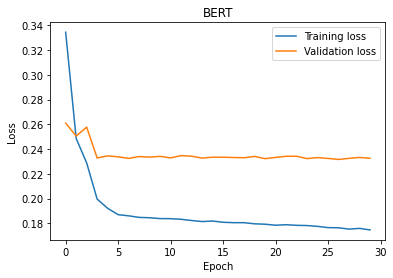

In [59]:
plt.plot(range(len(hisory5.history["loss"])), hisory5.history["loss"], hisory5.history["val_loss"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training loss", "Validation loss"])
plt.title('BERT')
plt.show()

In [62]:
y_pred = model.predict([test_title_encodings,test_description_encodings,test_attributes_encodings,test_search_encodings])


rmse = mean_squared_error(y_pred,y_test,squared=False)
mse = mean_squared_error(y_pred,y_test)
mae = median_absolute_error(y_pred,y_test)

print("RMSE on test data :",rmse)
print("MSE on test data  :",mse)
print("MAE on test data  :",mae)

RMSE on test data : 0.4807808525831549
MSE on test data  : 0.2311502282105853
MAE on test data  : 0.35337480068206784


Text(0, 0.5, 'Actual Relevance')

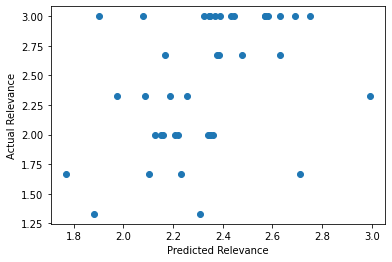

In [64]:
plt.scatter(y_pred[:40],y_test[:40])
plt.xlabel("Predicted Relevance")
plt.ylabel("Actual Relevance")

In [76]:
import time
t = time.time()

title_encodings = sbert_model.encode(test["preprocessed_title"].values[:1])
description_encodings = sbert_model.encode(test["preprocessed_description"].values[:1])
attributes_encodings = sbert_model.encode(test["preprocessed_attributes"].values[:1])
search_encodings = sbert_model.encode(test["search_term"].values[:1])

pred = model.predict([title_encodings,description_encodings,attributes_encodings,search_encodings])
time_taken = time.time()-t
print("Time taken by Sentence Bert model to predict the relevance: ",time_taken)

Time taken by Sentence Bert model to predict the relevance:  0.13098597526550293


---------------------------------------------------------------------------------------------------  The End --------------------------------------------------------------------------------